In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm


#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time
from scipy.special import logsumexp

In [184]:
#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [185]:
#==========================Gaussian Target Distribution==========================
def target_pdf(x, mu=0, sigma=1):
    """
    Compute the PDF of a Gaussian distribution with mean 0 and standard deviation 1.
    """
    return norm.pdf(x, mu, sigma)


In [186]:
def metropolis_hastings(xo, thinning, burnin, N, step_size):


    """
    Perform Metropolis-Hastings sampling to generate samples from a Gaussian distribution.
    
    Parameters:
    mu (float): Mean of the Gaussian distribution.
    sigma (float): Standard deviation of the Gaussian distribution.
    N (int): Number of samples to generate.
    
    Returns:
    np.ndarray: Array of samples from the Gaussian distribution.
    """
    samples = []
    x_current = xo  # Starting point
    
    for _ in range(N):
        # Propose a new sample from a normal distribution centered at the current sample
        x_proposed = x_current + rng.uniform(-step_size, step_size)
        
        # Compute acceptance ratio
        acceptance_ratio = target_pdf(x_proposed) / target_pdf(x_current) # this ratio assumes, that q(x_proposed | x_current) = q(x_current | x_proposed) = 1, which is the case for symmetric proposal distributions
        
        # Accept or reject the proposed sample
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed
        
        samples.append(x_current)
    # Thinning: only keep every 'thinning'-th sample
    samples = samples[::thinning]
    # Burn-in: discard the first 'burnin' samples
    samples = samples[burnin:]
    samples = np.array(samples)
    
    return np.array(samples)

    # Generate N samples from the target distribution (standard normal) using rng

'''x_samples = metropolis_hastings(np.random.uniform(-2, 2), 10, 1000, N, 2)
'''

'x_samples = metropolis_hastings(np.random.uniform(-2, 2), 10, 1000, N, 2)\n'

In [187]:
def importance_integration(f, N, rng, m_chain):
    # Compute the importance weights
    weights = f(m_chain) / target_pdf(m_chain)  # PDF of the target distribution
    estimate = np.mean(weights)  # Mean of the weights as the estimator of the integral
    
    return estimate

In [188]:
# Define the function f(x) = e^(-x^2)
def f(x):
    return np.exp(-x**2)
'''
N= 80000  # Number of samples

estimate= importance_integration(f, N, rng)

print(estimate)'''


'\nN= 80000  # Number of samples\n\nestimate= importance_integration(f, N, rng)\n\nprint(estimate)'

Generating MCMC chain...
Performing MCMC integration with binning analysis...
750

MCMC INTEGRATION RESULTS
Estimate: 1.754598
True value (√π): 1.772454
Error: 0.017856

VARIANCE ANALYSIS:
Naive variance: 0.00016415
Corrected variance: 0.00017774
Variance inflation factor: 1.08

STANDARD ERRORS:
Naive std error: 0.012812
Corrected std error: 0.013332
Error underestimation factor: 1.04

AUTOCORRELATION:
Integrated autocorr. time (τ_int): 1.08
Effective sample size: 2771
Efficiency: 92.4%


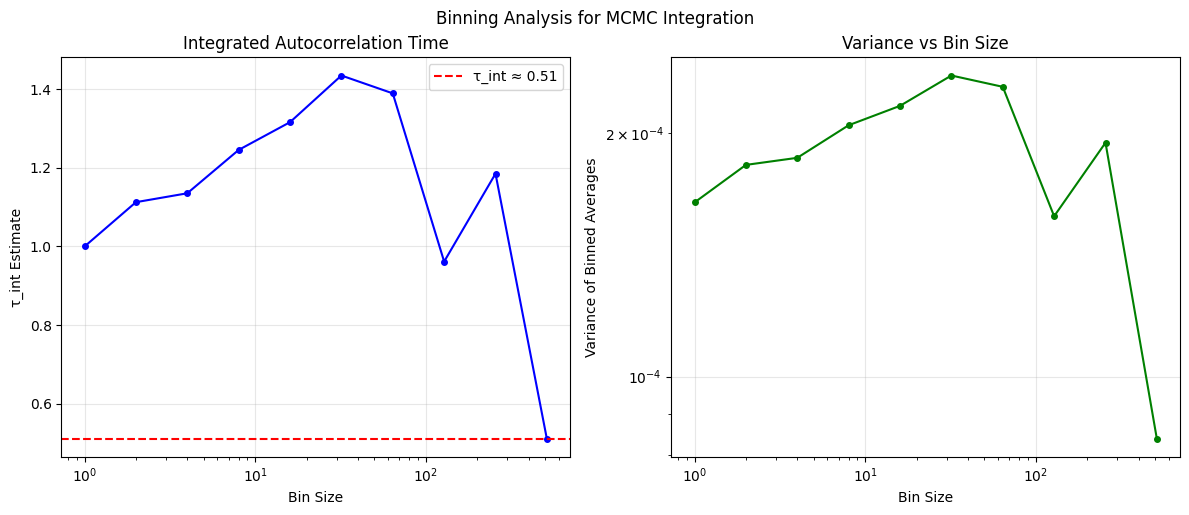


CONVERGENCE ANALYSIS
1000
N= 5000: Estimate=1.7634, Corrected SE=0.01914, τ_int=3.0
1250
N= 6000: Estimate=1.7840, Corrected SE=0.01771, τ_int=3.2
1500
N= 7000: Estimate=1.7646, Corrected SE=0.01745, τ_int=3.8
1750
N= 8000: Estimate=1.7681, Corrected SE=0.01495, τ_int=3.1
2000
N= 9000: Estimate=1.7671, Corrected SE=0.01328, τ_int=3.0
2250
N=10000: Estimate=1.7542, Corrected SE=0.01485, τ_int=3.9
2875
N=12500: Estimate=1.7783, Corrected SE=0.01172, τ_int=3.2
3500
N=15000: Estimate=1.7639, Corrected SE=0.01040, τ_int=3.1
4125
N=17500: Estimate=1.7740, Corrected SE=0.00962, τ_int=3.2
4750
N=20000: Estimate=1.7625, Corrected SE=0.00927, τ_int=3.3
6000
N=25000: Estimate=1.7673, Corrected SE=0.00804, τ_int=3.2


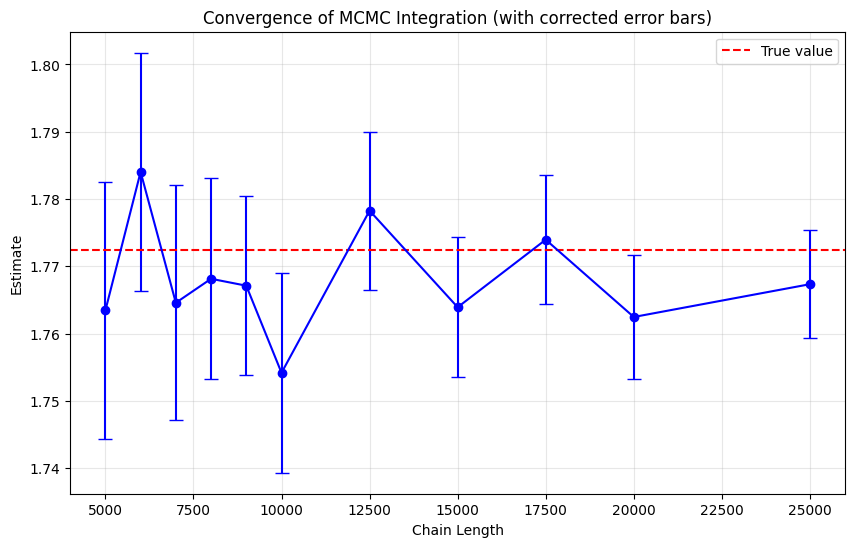

In [190]:
# ======================================================================
# BINNING METHOD FOR AUTOCORRELATION TIME
# ======================================================================

def binning_analysis(data, max_bin_size=None, min_bins=4):
    """
    Perform binning analysis to estimate autocorrelation time.
    
    Parameters:
    -----------
    data : array_like
        Time series data (e.g., MCMC samples or observable values)
    max_bin_size : int, optional
        Maximum bin size to consider. If None, uses N//min_bins
    min_bins : int, optional
        Minimum number of bins to maintain
    
    Returns:
    --------
    bin_sizes : array
        Array of bin sizes used
    variances : array
        Variance of binned averages for each bin size
    tau_int_estimates : array
        Integrated autocorrelation time estimates
    plateau_tau : float
        Best estimate of tau_int from plateau region
    """
    data = np.array(data)
    N = len(data)
    
    if max_bin_size is None:
        max_bin_size = N // min_bins
    
    # Range of bin sizes to test (powers of 2 work well)
    print(max_bin_size)
    max_power = int(np.log2(max_bin_size))
    bin_sizes = [2**i for i in range(max_power + 1) if 2**i <= max_bin_size]
    
    variances = []
    naive_var = np.var(data, ddof=1) / N  # Naive variance assuming independence
    
    for bin_size in bin_sizes:
        n_bins = N // bin_size
        if n_bins < min_bins:
            continue
            
        # Create bins
        binned_data = data[:n_bins * bin_size].reshape(n_bins, bin_size)
        bin_averages = np.mean(binned_data, axis=1)
        
        # Variance of bin averages
        var_bins = np.var(bin_averages, ddof=1) / n_bins
        variances.append(var_bins)
    
    # Trim bin_sizes to match variances length
    bin_sizes = bin_sizes[:len(variances)]
    variances = np.array(variances)
    
    # Estimate tau_int for each bin size
    tau_int_estimates = variances / naive_var
    
    # Find plateau region (where tau_int stabilizes)
    plateau_tau = find_plateau(bin_sizes, tau_int_estimates)
    
    return np.array(bin_sizes), variances, tau_int_estimates, plateau_tau

def find_plateau(bin_sizes, tau_estimates, window=3, tolerance=0.1):
    """
    Find the plateau value in tau_int estimates.
    
    Parameters:
    -----------
    bin_sizes : array
        Bin sizes
    tau_estimates : array
        Corresponding tau_int estimates
    window : int
        Size of sliding window for plateau detection
    tolerance : float
        Relative tolerance for plateau detection
    
    Returns:
    --------
    float
        Best estimate of tau_int from plateau region
    """
    if len(tau_estimates) < window:
        return tau_estimates[-1]
    
    # Look for regions where tau_int is stable
    for i in range(len(tau_estimates) - window + 1):
        window_values = tau_estimates[i:i+window]
        mean_val = np.mean(window_values)
        rel_std = np.std(window_values) / mean_val
        
        if rel_std < tolerance:
            # Found a plateau
            return mean_val
    
    # If no clear plateau, return the value at moderate bin size
    mid_idx = len(tau_estimates) // 2
    return tau_estimates[mid_idx]

# ======================================================================
# CORRECTED VARIANCE CALCULATION FOR MCMC INTEGRATION
# ======================================================================

def mcmc_integration_with_binning(f, chain, kde_pdf, detailed_analysis=True):
    """
    Perform MCMC integration with proper variance correction using binning.
    
    Parameters:
    -----------
    f : function
        Function to integrate
    chain : array
        MCMC chain samples
    kde_pdf : function
        KDE probability density function
    detailed_analysis : bool
        Whether to return detailed binning analysis
    
    Returns:
    --------
    result : dict
        Dictionary containing:
        - estimate: Monte Carlo estimate
        - naive_variance: Naive variance (assuming independence)
        - corrected_variance: Variance corrected for autocorrelation
        - naive_stderr: Naive standard error
        - corrected_stderr: Corrected standard error
        - tau_int: Integrated autocorrelation time
        - binning_data: (if detailed_analysis=True) Full binning analysis
    """
    # Calculate importance weights
    weights = f(chain) / kde_pdf(chain)
    estimate = np.mean(weights)
    
    # Naive variance (assuming independence)
    naive_variance = np.var(weights, ddof=1) / len(weights)
    naive_stderr = np.sqrt(naive_variance)
    
    # Binning analysis to find autocorrelation time
    bin_sizes, variances, tau_estimates, tau_int = binning_analysis(weights)
    
    # Corrected variance accounting for autocorrelation
    corrected_variance = naive_variance * tau_int
    corrected_stderr = np.sqrt(corrected_variance)
    
    result = {
        'estimate': estimate,
        'naive_variance': naive_variance,
        'corrected_variance': corrected_variance,
        'naive_stderr': naive_stderr,
        'corrected_stderr': corrected_stderr,
        'tau_int': tau_int,
        'effective_sample_size': len(weights) / tau_int
    }
    
    if detailed_analysis:
        result['binning_data'] = {
            'bin_sizes': bin_sizes,
            'variances': variances,
            'tau_estimates': tau_estimates
        }
    
    return result

# ======================================================================
# DEMONSTRATION AND PLOTTING
# ======================================================================

def plot_binning_analysis(binning_data, title="Binning Analysis"):
    """Plot the results of binning analysis."""
    bin_sizes = binning_data['bin_sizes']
    tau_estimates = binning_data['tau_estimates']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot tau_int vs bin size
    ax1.semilogx(bin_sizes, tau_estimates, 'bo-', markersize=4)
    ax1.axhline(y=binning_data['tau_estimates'][-1], color='r', linestyle='--', 
                label=f'τ_int ≈ {binning_data["tau_estimates"][-1]:.2f}')
    ax1.set_xlabel('Bin Size')
    ax1.set_ylabel('τ_int Estimate')
    ax1.set_title('Integrated Autocorrelation Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot variance vs bin size
    ax2.loglog(bin_sizes, binning_data['variances'], 'go-', markersize=4)
    ax2.set_xlabel('Bin Size')
    ax2.set_ylabel('Variance of Binned Averages')
    ax2.set_title('Variance vs Bin Size')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

# ======================================================================
# EXAMPLE USAGE
# ======================================================================

if __name__ == "__main__":
    # Define the function to integrate (your example)
    def f(x):
        return np.exp(-x**2)  # Gaussian function
    
    # Generate MCMC chain
    print("Generating MCMC chain...")
    N = 20000
   
    
    ''' 
    def metropolis_hastings(xo, thinning, burnin, N, step_size):
    '''  

    chain = metropolis_hastings(rng.uniform(-4, 4), 5, 1000, N, 3)
    
    # Perform integration with binning analysis
    print("Performing MCMC integration with binning analysis...")
    result = mcmc_integration_with_binning(f, chain, target_pdf, detailed_analysis=True)
    
    # Print results
    print("\n" + "="*60)
    print("MCMC INTEGRATION RESULTS")
    print("="*60)
    print(f"Estimate: {result['estimate']:.6f}")
    print(f"True value (√π): {np.sqrt(np.pi):.6f}")
    print(f"Error: {abs(result['estimate'] - np.sqrt(np.pi)):.6f}")
    print()
    print("VARIANCE ANALYSIS:")
    print(f"Naive variance: {result['naive_variance']:.8f}")
    print(f"Corrected variance: {result['corrected_variance']:.8f}")
    print(f"Variance inflation factor: {result['corrected_variance']/result['naive_variance']:.2f}")
    print()
    print("STANDARD ERRORS:")
    print(f"Naive std error: {result['naive_stderr']:.6f}")
    print(f"Corrected std error: {result['corrected_stderr']:.6f}")
    print(f"Error underestimation factor: {result['corrected_stderr']/result['naive_stderr']:.2f}")
    print()
    print("AUTOCORRELATION:")
    print(f"Integrated autocorr. time (τ_int): {result['tau_int']:.2f}")
    print(f"Effective sample size: {result['effective_sample_size']:.0f}")
    print(f"Efficiency: {result['effective_sample_size']/len(chain)*100:.1f}%")
    
    # Plot binning analysis
    plot_binning_analysis(result['binning_data'], "Binning Analysis for MCMC Integration")
  
    
    # Compare with different chain lengths
    print("\n" + "="*60)
    print("CONVERGENCE ANALYSIS")
    print("="*60)
    
    chain_lengths = [5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 25000]
    results_comparison = []
    
    for N in chain_lengths:
        chain_temp = metropolis_hastings(rng.uniform(-4, 4), 1, 1000, N, 3)
        result_temp = mcmc_integration_with_binning(f, chain_temp, target_pdf, detailed_analysis=False)
        results_comparison.append(result_temp)
        
        print(f"N={N:5d}: Estimate={result_temp['estimate']:.4f}, "
              f"Corrected SE={result_temp['corrected_stderr']:.5f}, "
              f"τ_int={result_temp['tau_int']:.1f}")
    
    # Plot convergence
    estimates = [r['estimate'] for r in results_comparison]
    errors = [r['corrected_stderr'] for r in results_comparison]
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(chain_lengths, estimates, yerr=errors, fmt='bo-', capsize=5)
    plt.axhline(y=np.sqrt(np.pi), color='r', linestyle='--', label='True value')
    plt.xlabel('Chain Length')
    plt.ylabel('Estimate')
    plt.title('Convergence of MCMC Integration (with corrected error bars)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()